In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import pickle
from tqdm import trange
import blimpy as bl
%matplotlib inline

bshuf filter already loaded, skip it.
zfp filter already loaded, skip it.


In [2]:
print("Blimpy version:", bl.__version__)

Blimpy version: 2.0.10


First we will read in the data that I processed on GCP

For simplicity, I will start with the L-band files from turboSETI, and then make a function so that I can repeat the process on other bands as well as the energy detection data

In [3]:
dir_path = "/home/danielb/fall_2021/spectral_occupancy/"
ts = dir_path + "turbo-seti/"
ed = dir_path + "energy-detection/"
fine = ed + "fine_channel_fraction/"

In [4]:
ts_pickles = glob.glob(ts+"*pkl")
ed_pickles = glob.glob(ed+"*pkl")

In [5]:
def read_pickle(pickle_path):
    with open(pickle_path, "rb") as f:
        contents = pickle.load(f)
    return contents

In [6]:
l_band = read_pickle(ts_pickles[2])

In [7]:
def sample_spectrum(spectral_occupancy):
    return np.random.random(size=len(spectral_occupancy))

def simulate_cadence(spectral_occupancy):
    on_target = np.empty(shape=(3, len(spectral_occupancy)), dtype=bool)
    off_target= np.empty(shape=(3, len(spectral_occupancy)), dtype=bool)
    for i in range(3):
        on_target[i,:] = sample_spectrum(spectral_occupancy) <= spectral_occupancy
    
    for i in range(3):
        off_target[i, :] = sample_spectrum(spectral_occupancy) <= spectral_occupancy
    
    return on_target, off_target

def signal_search(spectral_occupancy):
    """
    currently set to filter level 3:
    events that are present in *ALL* ons
    and found in *NO* offs 
    """
    on, off = simulate_cadence(spectral_occupancy)
    # signals should be present in all ons
    all_on = np.sum(on, axis=0) == 3
    
    # signals should be absent in all offs
    no_off = np.sum(off, axis=0) == 0
    
    #check that hits are present in "ons" and absent in "offs"
    hit_detection = (all_on & no_off)
    
    return hit_detection

def search_n_times(spectral_occupancy, N_iterations=10000):
    search_results = np.empty(shape=(N_iterations, len(spectral_occupancy)))
    
    for i in trange(N_iterations):
        search_results[i,:] = signal_search(spectral_occupancy)
    
    return search_results

In [8]:
results = search_n_times(l_band["bin_heights"])
event_counts = np.sum(results, axis=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1958.24it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:17<00:00, 574.32it/s]


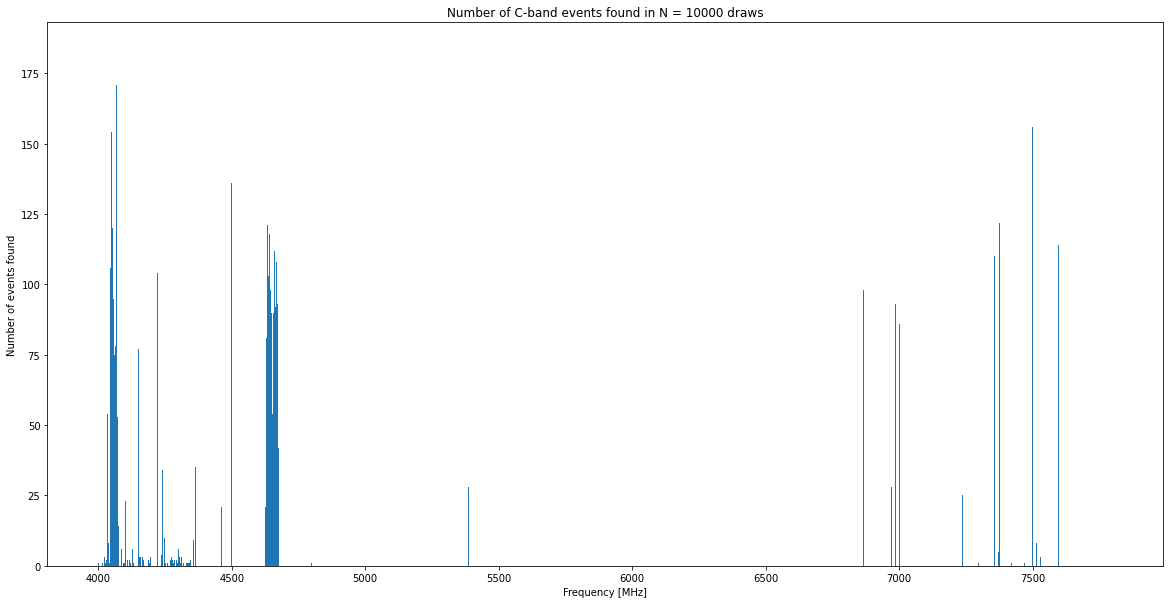

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 7278.80it/s]


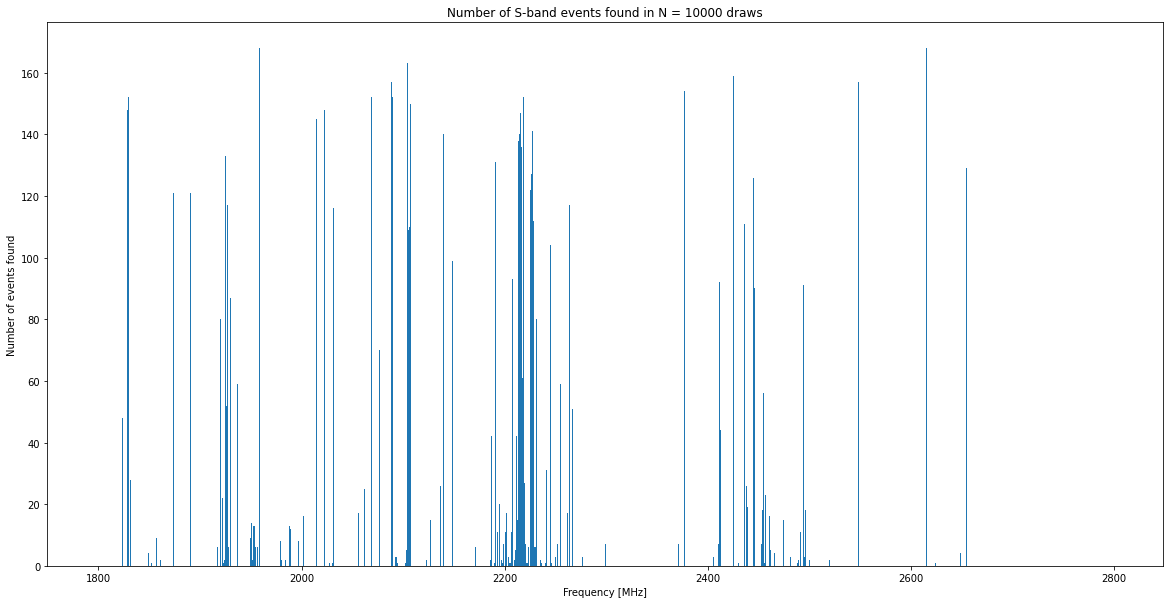

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 7118.66it/s]


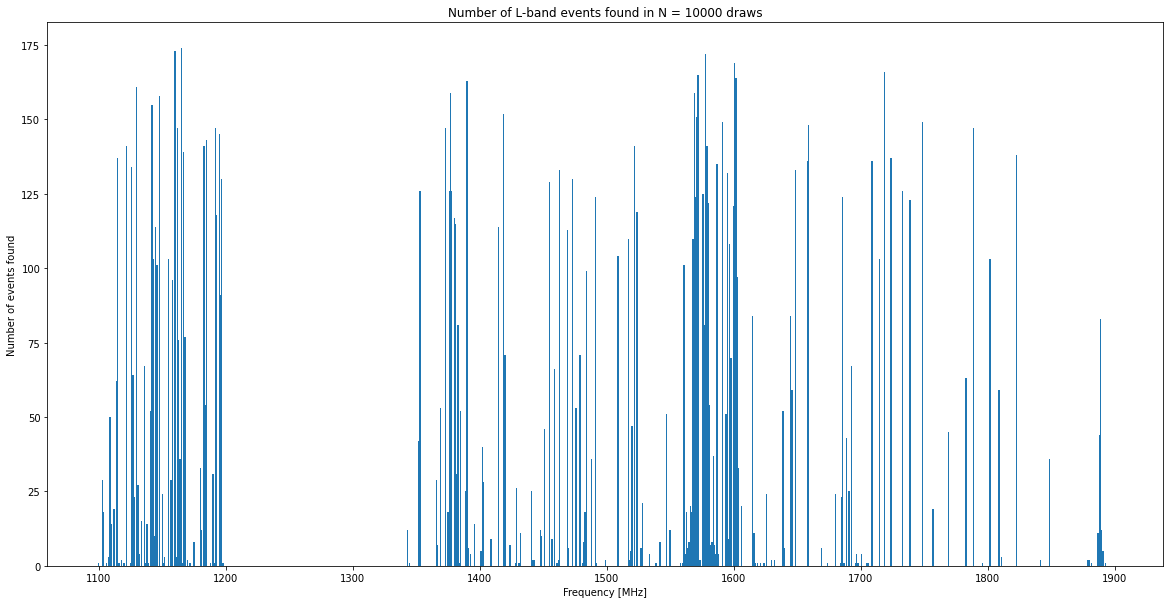

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2395.45it/s]


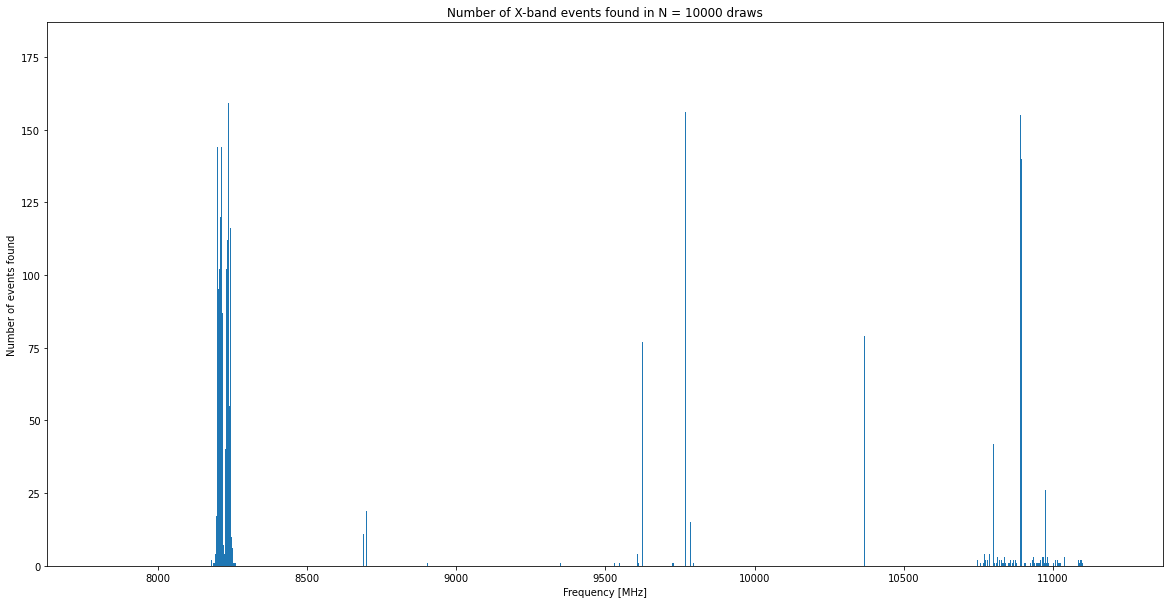

In [9]:
for i in range(4):
    data = ts_pickles[i]
    data = read_pickle(data)

    results = search_n_times(data["bin_heights"])
    event_counts = np.sum(results, axis=0)

    plt.figure(figsize=(20,10))
    plt.bar(data["bin_edges"][:-1], event_counts, width=1)
    plt.title("Number of %s-band events found in N = %i draws"%(data["band"], len(results)))
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("Number of events found")
    plt.show()

# repeating the process with energy detection data

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2198.01it/s]


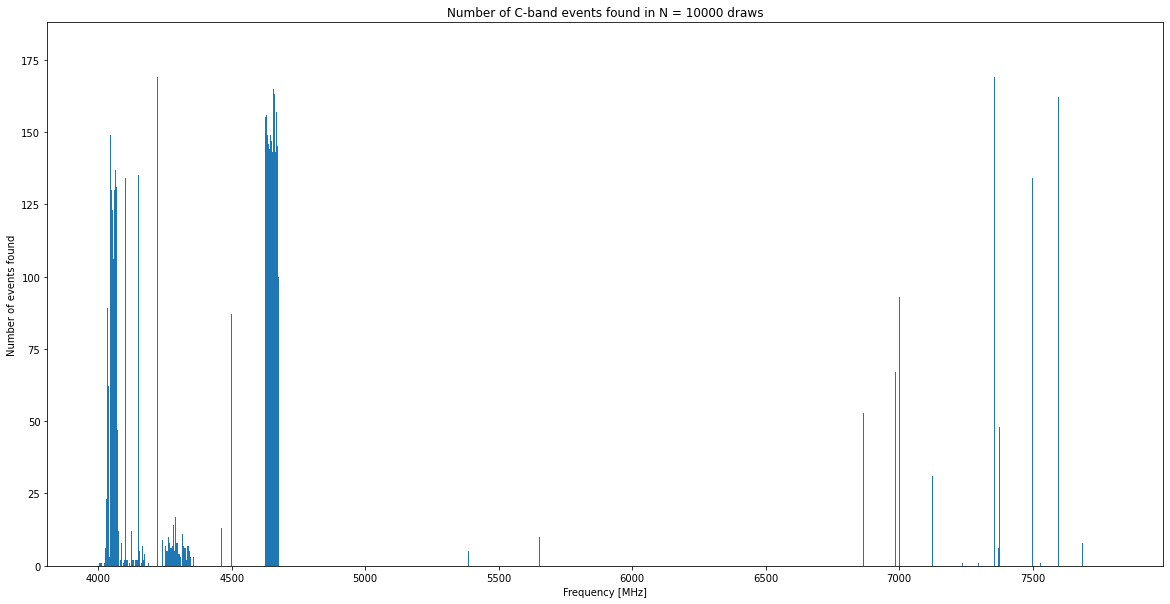

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 7800.67it/s]


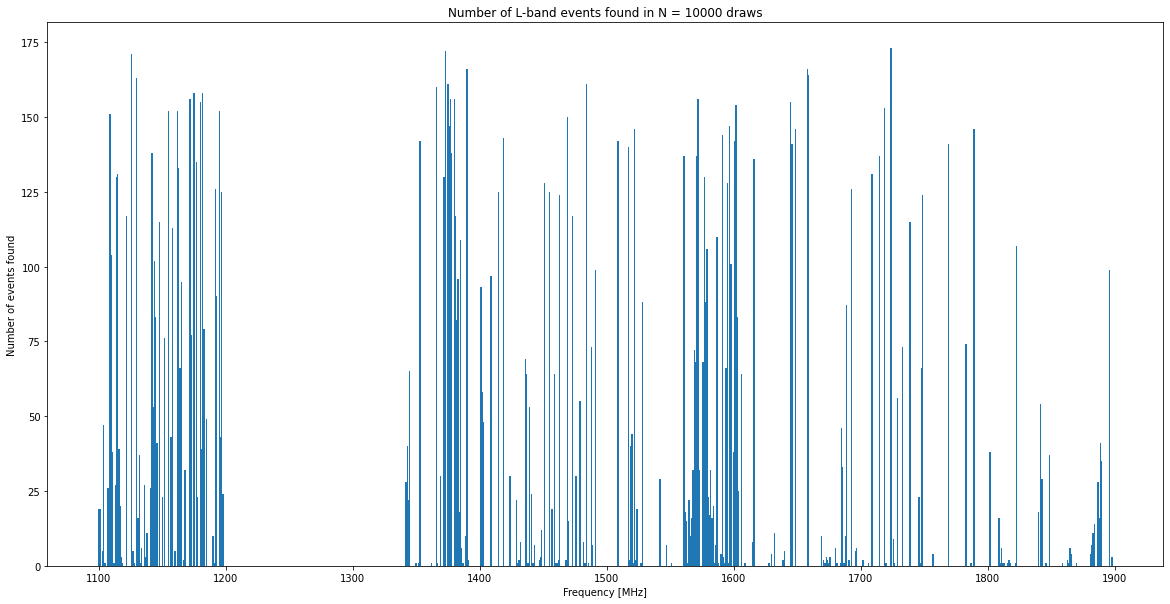

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5819.26it/s]


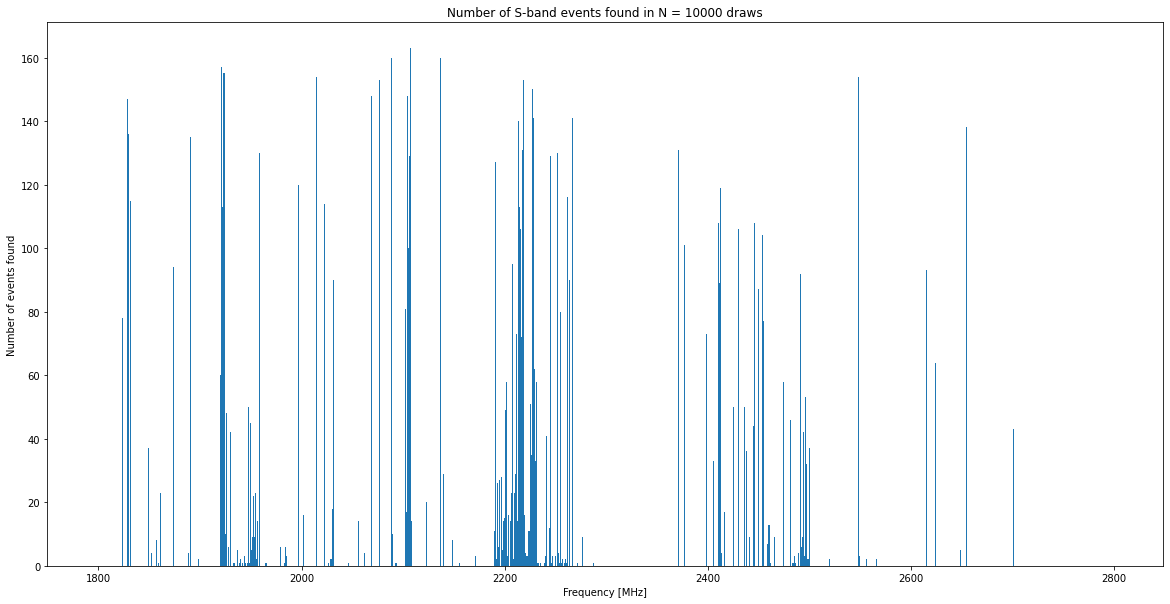

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2082.97it/s]


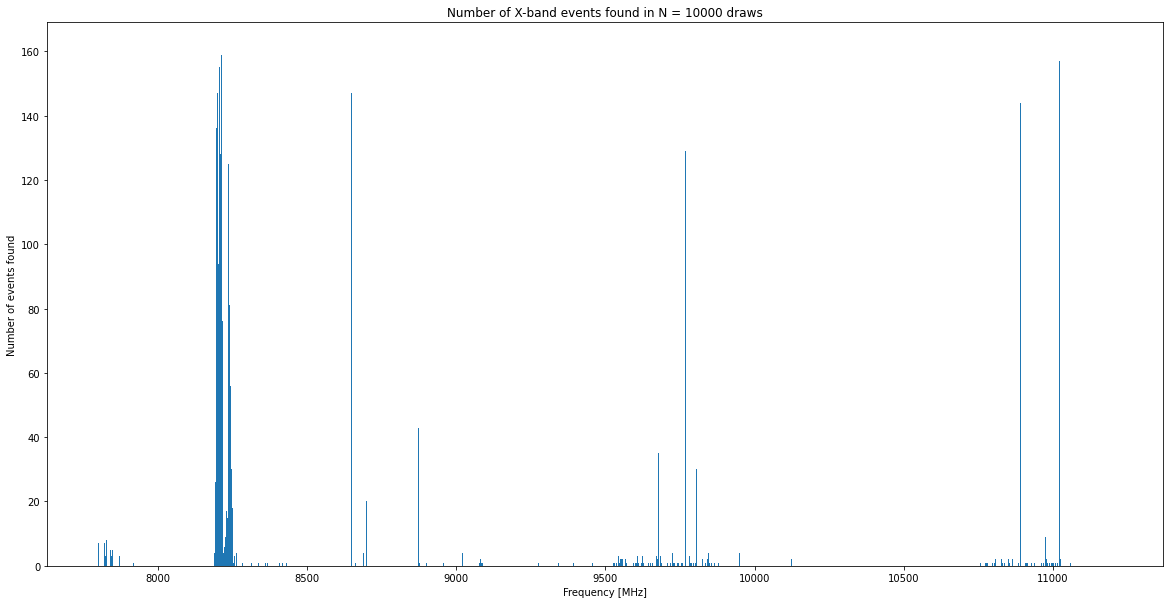

In [10]:
for i in range(4):
    data = ed_pickles[i]
    data = read_pickle(data)

    results = search_n_times(data["bin_heights"])
    event_counts = np.sum(results, axis=0)

    plt.figure(figsize=(20,10))
    plt.bar(data["bin_edges"][:-1], event_counts, width=1)
    plt.title("Number of %s-band events found in N = %i draws"%(data["band"], len(results)))
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("Number of events found")
    plt.show()

# Ratio of bin height vs frequency comparing energy detection and turboSETI

In [11]:
ed_data = read_pickle(ed_pickles[1])
ts_data = read_pickle(ts_pickles[2])

/tmp/ipykernel_2260088/2297618612.py:1: RuntimeWarning: divide by zero encountered in true_divide
  ed_over_ts = ed_data["bin_heights"]/ts_data["bin_heights"]
/tmp/ipykernel_2260088/2297618612.py:1: RuntimeWarning: invalid value encountered in true_divide
  ed_over_ts = ed_data["bin_heights"]/ts_data["bin_heights"]
/tmp/ipykernel_2260088/2297618612.py:2: RuntimeWarning: divide by zero encountered in true_divide
  ts_over_ed = ts_data["bin_heights"]/ed_data["bin_heights"]
/tmp/ipykernel_2260088/2297618612.py:2: RuntimeWarning: invalid value encountered in true_divide
  ts_over_ed = ts_data["bin_heights"]/ed_data["bin_heights"]


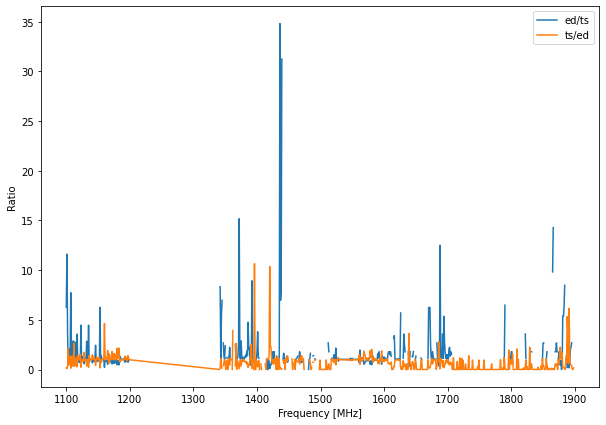

In [12]:
ed_over_ts = ed_data["bin_heights"]/ts_data["bin_heights"]
ts_over_ed = ts_data["bin_heights"]/ed_data["bin_heights"]

plt.figure(figsize=(10,7))
plt.plot(ts_data["bin_edges"][:-1], ed_over_ts, label="ed/ts")
plt.plot(ts_data["bin_edges"][:-1], ts_over_ed, label="ts/ed")
plt.legend()
plt.xlabel("Frequency [MHz]")
plt.ylabel("Ratio")
# plt.yscale("log")
plt.show()

# Fraction of fine channels that detect a signal 

In [13]:
fine_pickles = glob.glob(fine+"*")
fine_pickles.sort()

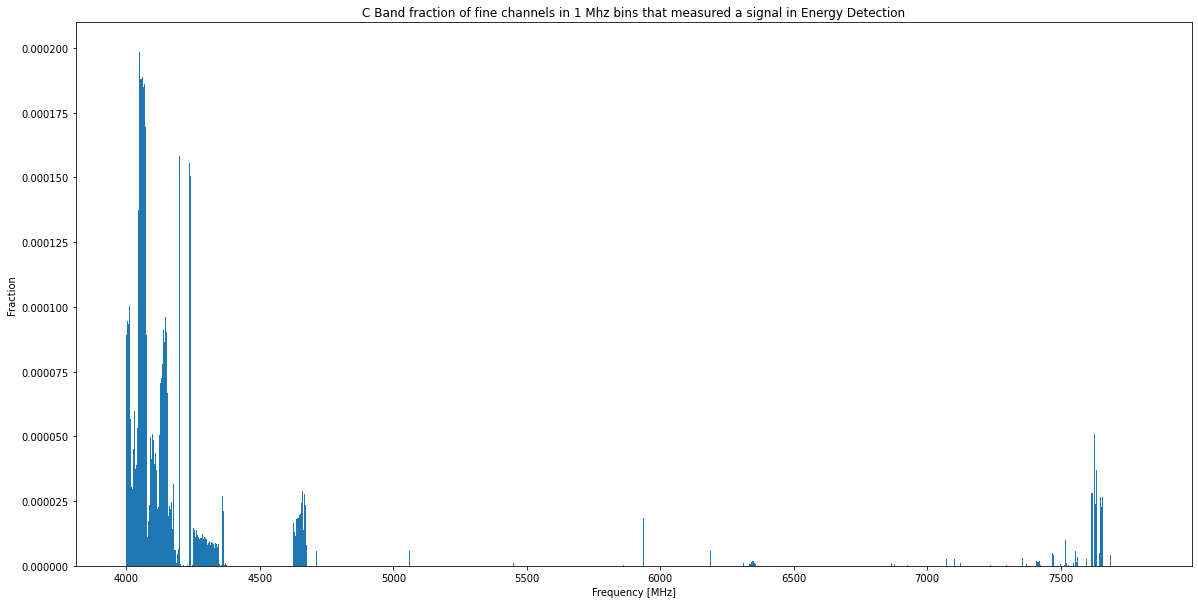

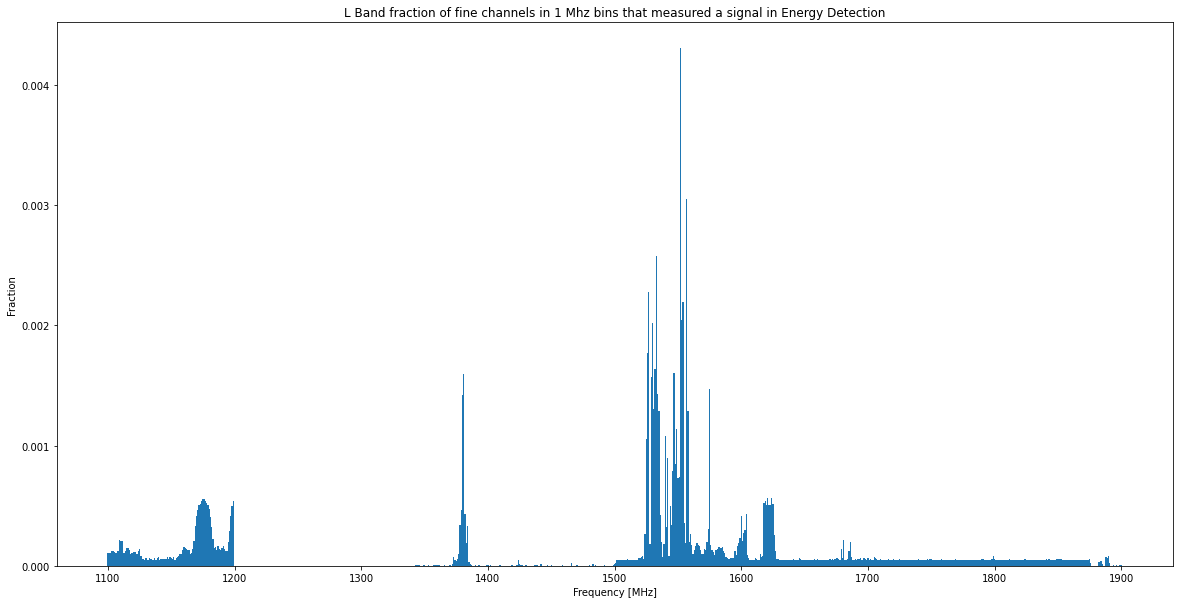

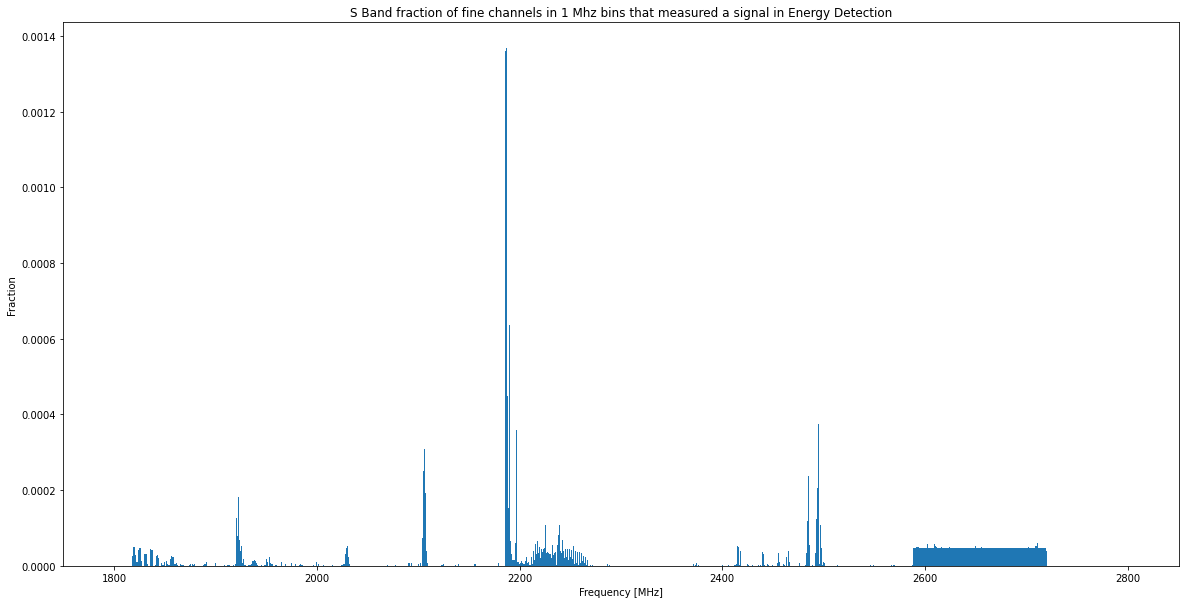

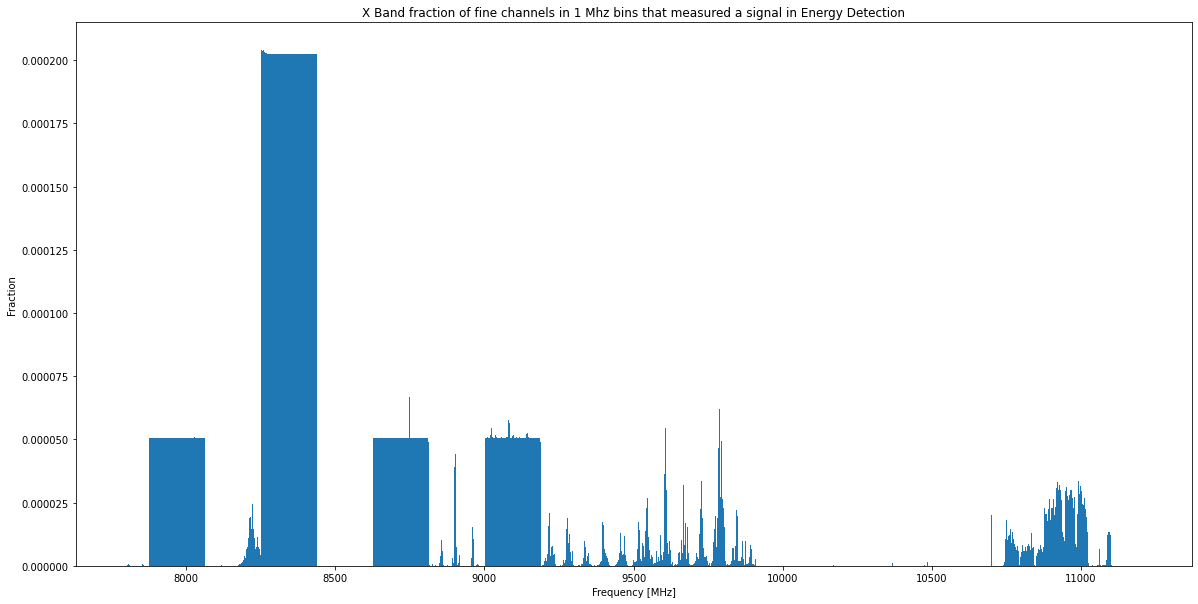

In [14]:
for i in range(4):
    fraction_data = read_pickle(fine_pickles[i])
    fractions = fraction_data["fine channel fraction"]
    frequencies = fraction_data["frequency bin"]
    band = fraction_data["band"]
    savepath = "/home/danielb/fall_2021/fine_channel_plots/%s_band_energy_detection_fine_channel_fraction.pdf"%band
    
    plt.figure(figsize=(20,10))
    plt.bar(frequencies, fractions, width=1)
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("Fraction")
    plt.title("%s Band fraction of fine channels in %s Mhz bins that measured a signal in Energy Detection"%(fraction_data["band"], fraction_data["bin_width"]))
    plt.savefig(savepath, bbox_inches='tight', transparent=False)

### Interesting details

X band has intervals with a much higher fraction than the surrounding

L band has an interval of constant fraction in frequencies between ~1650-1900 MHz



# Identifying strange files

In [15]:
xband = read_pickle(fine_pickles[3])
xband.keys()

dict_keys(['fine channel fraction', 'frequency bin', 'dataframe', 'bin_width', 'fine_channel_width', 'band', 'threshold', 'algorithm', 'n files'])

In [16]:
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_column", 10)

In [17]:
df = xband["dataframe"].T
df

,7800.0,7801.0,7802.0,7803.0,7804.0,...,11196.0,11197.0,11198.0,11199.0,11200.0
spliced_blc00010203040506o7o0111213141516o7o021222324252627_guppi_58810_14835_HIP94609_0038,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
spliced_blc00010203040506o7o0111213141516o7o021222324252627_guppi_58810_14512_TIC284450803_0037,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
spliced_blc40414243444546o7o0515253545556o7o061626364656667_guppi_58888_79017_TIC266500992_0031,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
spliced_blc00010203040506o7o0111213141516o7o021222324252627_guppi_58806_21195_TIC349827430_0053,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
spliced_blc40414243444546o7o0515253545556o7o061626364656667_guppi_58888_79336_HIP18962_0032,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
spliced_blc00010203040506o7o0111213141516o021222324252627_guppi_58806_42870_HIP75370_0126,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
spliced_blc00010203040506o7o0111213141516o7o021222324252627_guppi_58808_60850_TIC232967666_0050,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
spliced_blc10111213141516o7o0212223242526o7o031323334353637_guppi_58868_40320_TIC281731203_0019,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
spliced_blc00010203040506o7o0111213141516o7o021222324252627_guppi_58806_08997_TIC372757221_0015,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0


In [18]:
colnames = np.arange(7850, 8100, dtype=float)
keep = []
for label in colnames:
    keep.append(label)
temp = np.mean(df[colnames], axis=0)

<BarContainer object of 250 artists>

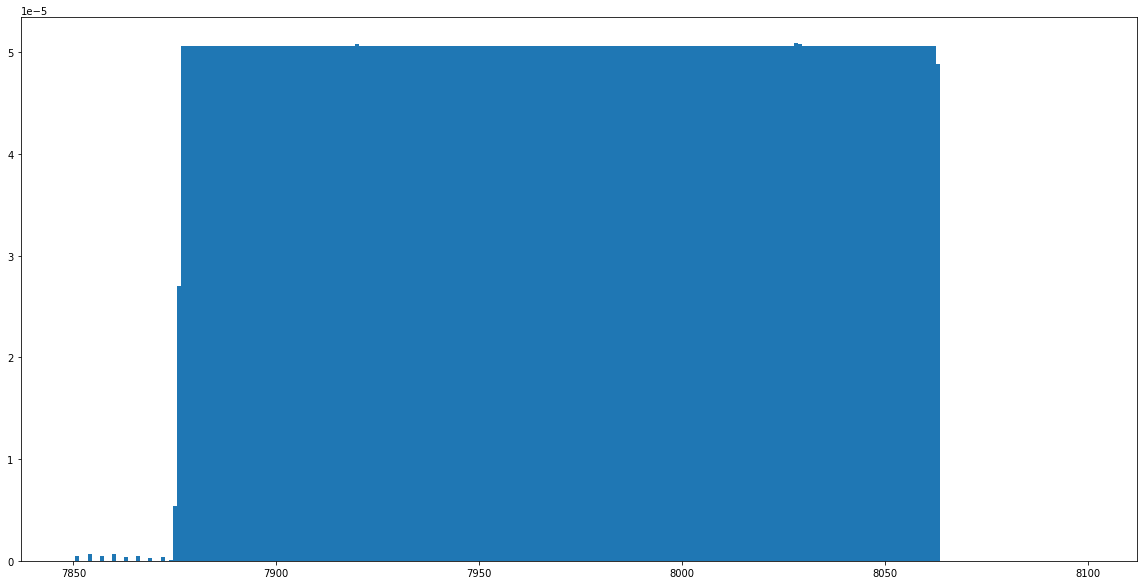

In [19]:
plt.figure(figsize=(20,10))
plt.bar(colnames, temp, 1)

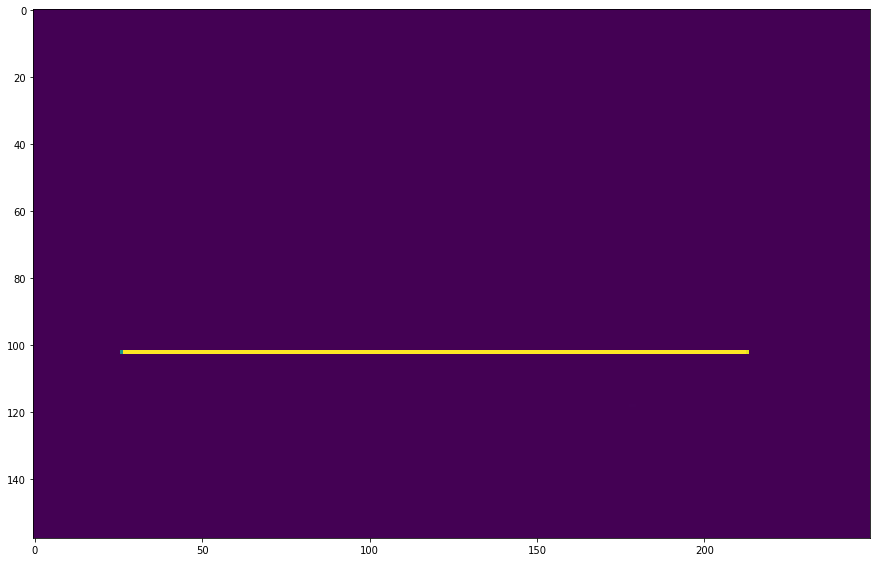

In [20]:
arr = np.array(df[colnames])

plt.figure(figsize=(15,15))
plt.imshow(arr)

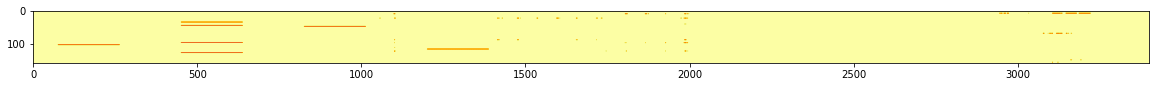

In [21]:
plt.figure(figsize=(20,10))
plt.imshow(np.array(df)>1e-3, cmap="inferno_r");
# plt.colorbar()

In [22]:
def z_score(df):
    arr = np.array(df)
    mean = np.mean(arr, axis=0)
    sd = np.std(arr, axis=0)
    no_data = np.where(np.sum(arr, axis=0) == 0)
    # correct for zero standard deviations
    sd[no_data] = np.inf
    mask = np.where(sd==0)
    sd[mask] = 1e-9
    z_tbl = (arr - mean)/sd
    return z_tbl

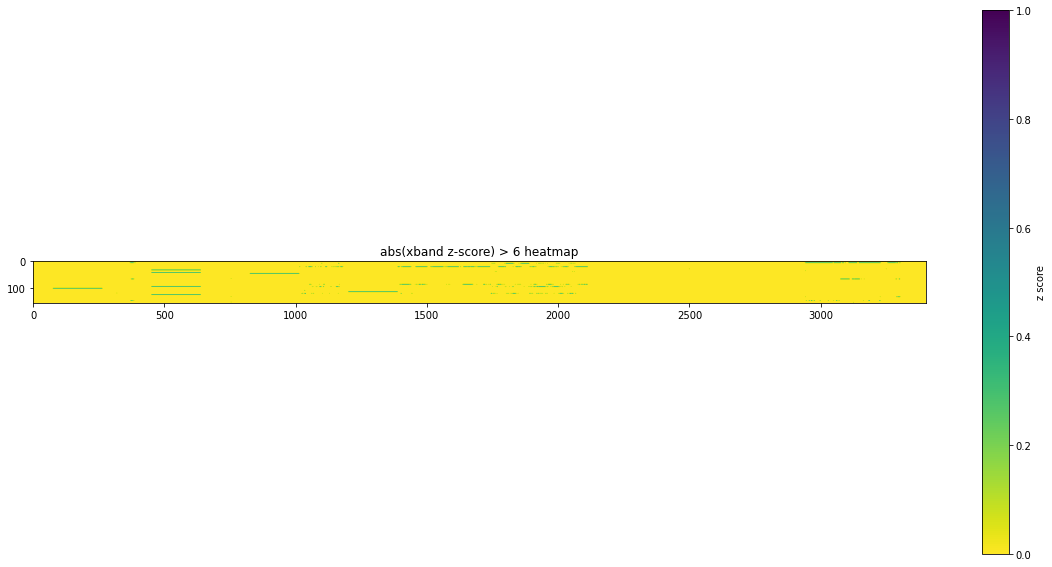

In [43]:
z_val = 6

plt.figure(figsize=(20,10))
plt.imshow(np.abs(z_score(df)) > z_val, cmap="viridis_r")
plt.colorbar(label="z score")
plt.title("abs(xband z-score) > %s heatmap"%z_val)
plt.savefig("xband_heatmap.pdf")

In [24]:
def high_z_score(df, min_z):
    # want to identify flagged frequencies as well as file names
    z_tbl = z_score(df)
    bad_mask = np.where(np.abs(z_tbl) > min_z)[0]
    bad_mask = np.unique(bad_mask)
    flagged_files =  df.iloc[bad_mask]
    return flagged_files.index

def high_mean(df, min_mean):
    arr = np.array(df)
    bad_mask = np.where(arr > min_mean)[0]
    bad_mask = np.unique(bad_mask)
    flagged_files =  df.iloc[bad_mask]
    return flagged_files.index

In [25]:
def flag_z(df, min_z):
    """
    Takes a DataFrame and minimum Z-score and returns 
    all the files with channels above this Z-score
    as well as the corresponding frequencies
    
    Will output two lists of the same length. The 
    first file will hold the filenames and the second 
    will hold the frequencies in that file that are 
    above the Z-score
    
    Arguments:
    -----------
    df : pandas.core.frame.DataFrame
        DataFrame containing the fine channel fraction data
    min_z : float
        the minimum allowed Z-score, above which files will
        be flagged
        
    Returns:
    ---------
    flagged_files : pandas.core.indexes.base.Index
        An array containing strings of the filenames
        of the flagged files
    flagged_freqs : list
        A list of frequencies that were flagged 
    """
    z_tbl = z_score(df)
    mask = np.where(np.abs(z_tbl) > min_z)
    stacked = np.vstack(mask)
    file_indx = np.unique(stacked[0])
    flagged_freqs = []
    for indx in file_indx:
        this_file = stacked[1][np.where(stacked[0] == indx)[0]]
        frequencies = np.array(df.T.iloc[this_file].index)
        flagged_freqs.append(frequencies)
    flagged_files = df.iloc[file_indx].index
    return flagged_files, flagged_freqs

In [44]:
freqs = np.arange(0,1000) + 7800
temp = df[freqs]
a = high_mean(temp, 1e-3)
a

Index(['spliced_blc00010203040506o7o0111213141516o0212224252627_guppi_58806_44811_HIP68589_0132',
       'spliced_blc00010203040506o7o0111213141516o7o0212224252627_guppi_58806_25893_TIC160268701_0068',
       'spliced_blc00010203040506o7o0111213141516o0222324252627_guppi_58806_46297_HIP66308_0137',
       'spliced_blc00010203040506o7o0111213141516o7o0212224252627_guppi_58806_33792_TIC230088370_0097',
       'spliced_blc00010203040506o7o0111213141516o7o0212223242627_guppi_58810_20178_HIP98100_0055',
       'spliced_blc00010203040506o7o0111213141516o7o0212224252627_guppi_58806_19083_TIC302518439_0046'],
      dtype='object')

In [ ]:
savepath = "/home/danielb/fall_2021/flagged_plots/z_score_flag/fraction/"

index = 5
lookup = df.T
plt.figure(figsize=(20,10))
plt.bar(df.columns, lookup[a[index]].values)
plt.title(a[index])
plt.savefig(savepath + a[index] + ".pdf", bbox_inches='tight', transparent=False);
# plt.xlim(8600,8850);

# Plotting examples of strange files

blimpy.io.base_reader WARNING  Setting data limit = 7.5 GB > 1 GB, please handle with care!
data loaded
extracting integration 0...


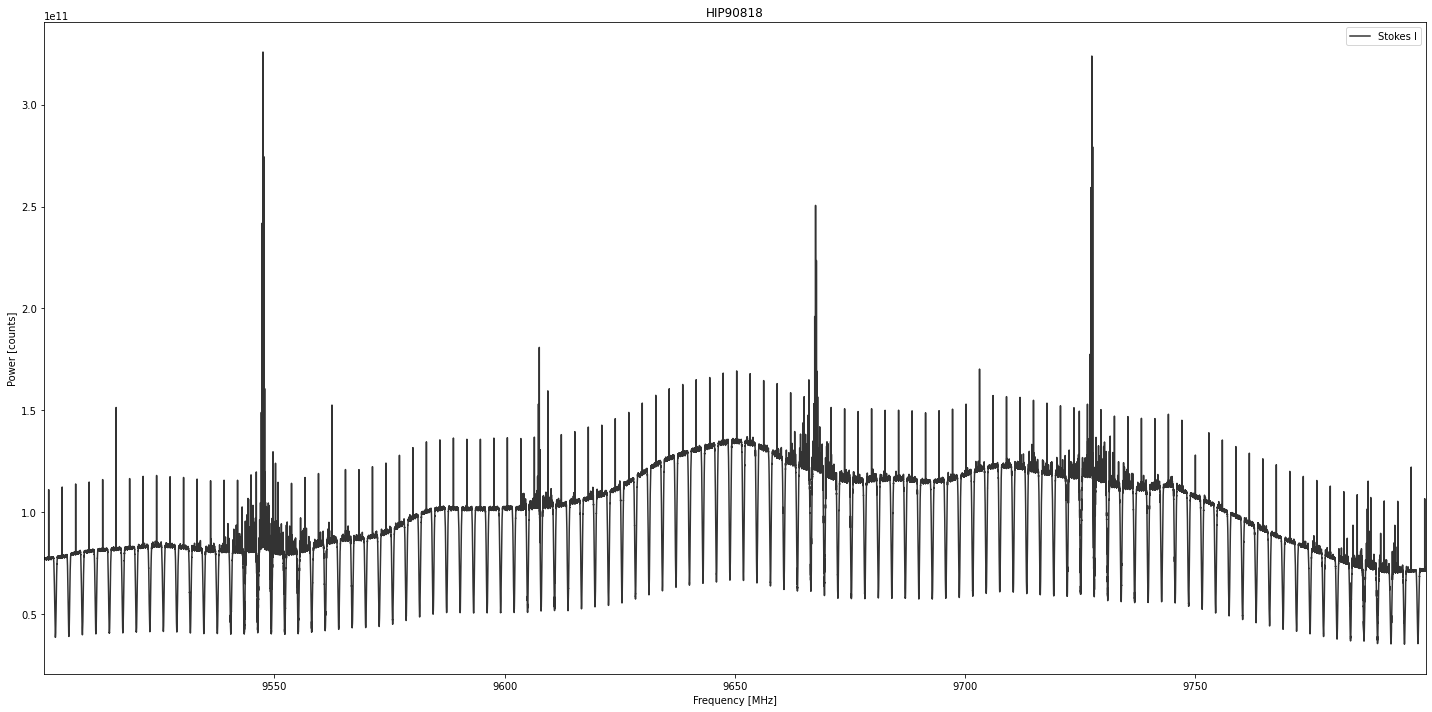

In [28]:
dir_path = "/home/gcsfuse/blpc0/bl_tess/x_band/"
h5_path = glob.glob(dir_path + a[index] + "*0.h5")[0]
f_start = 9500
f_stop = 9800

save_dir = "/home/danielb/fall_2021/flagged_plots/z_score_flag/spectrum/"
save_path = save_dir + a[index] + "_%s_to_%s.pdf"%(f_start, f_stop)

hf = bl.Waterfall(h5_path, f_start=f_start, f_stop=f_stop, max_load=7.5)
print("data loaded")
plt.figure(figsize=(20,10))
hf.plot_spectrum()
plt.tight_layout()
plt.savefig(save_path, bbox_inches='tight', transparent=False)
del hf

In [29]:
files, freqs = flag_z(df, 6)

In [30]:
len(freqs)

26

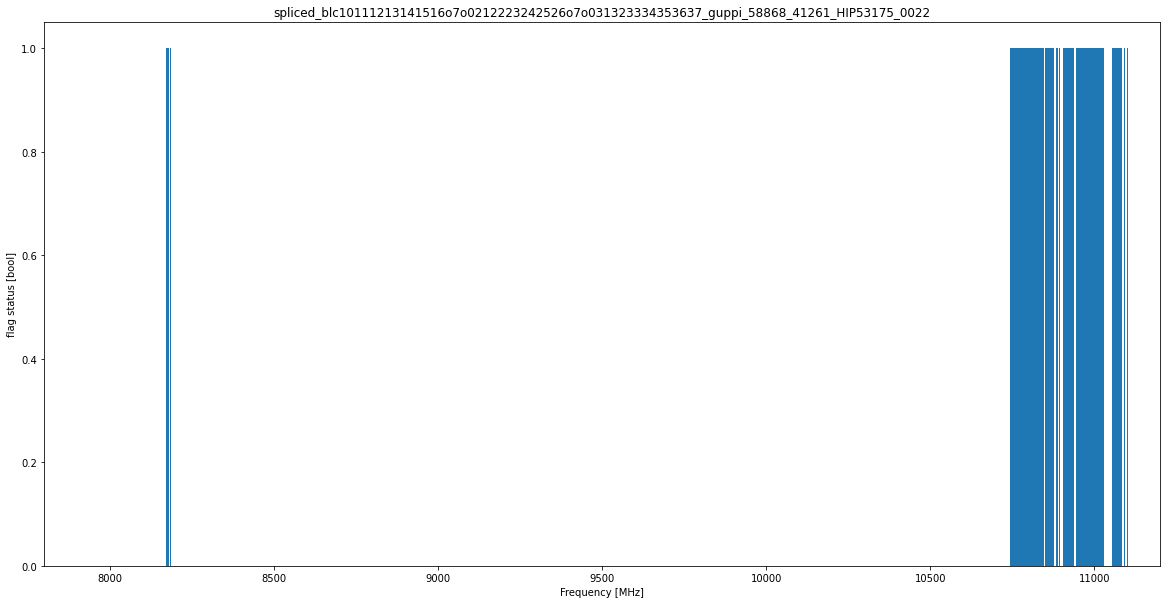

In [34]:
save_dir = "/home/danielb/plots/"

i = 0
plt.figure(figsize=(20,10))
plt.title(files[i])
plt.bar(freqs[i], 1, 1)
plt.xlim(7800, 11200)
plt.xlabel("Frequency [MHz]")
plt.ylabel("flag status [bool]")
plt.savefig(save_dir + files[i] + ".pdf", bbox_inches='tight', transparent=False);

In [35]:
# missing_nodes = []
# missing_nodes.append(files[8])
# missing_nodes.append(files[4])
# missing_nodes.append(files[10])

In [38]:
def count_missing_node(flagged_freqs):
    jumps = np.where(np.diff(flagged_freqs, n=2) != 0)
    splits = jumps[0][::2] + 2
    spectral_intervals = np.split(flagged_freqs, splits)
    nodes_missing = 0
    for interval in spectral_intervals:
        length = len(interval)
        if length == 187 or length == 188 or length == 189:
            nodes_missing += 1
    return nodes_missing

In [39]:
files, freqs = flag_z(df, 7)

total = np.empty(len(freqs))
for i,thing in enumerate(freqs):
    node = count_missing_node(thing)
    total[i] = node

In [40]:
np.sum(total)

3.0

In [41]:
def files_missing_nodes(df):
    files, freqs = flag_z(df, 2)
    
    flagged_files = []
    for i in range(len(files)):
        if count_missing_node(freqs[i]) > 0:
            flagged_files.append(files[i])
    return flagged_files

In [42]:
files_missing_nodes(df)

['spliced_blc00010203040506o7o0111213141516o0212224252627_guppi_58806_44811_HIP68589_0132',
 'spliced_blc00010203040506o7o0111213141516o7o0212224252627_guppi_58806_25893_TIC160268701_0068',
 'spliced_blc00010203040506o7o0111213141516o0222324252627_guppi_58806_46297_HIP66308_0137',
 'spliced_blc00010203040506o7o0111213141516o7o0212224252627_guppi_58806_33792_TIC230088370_0097',
 'spliced_blc00010203040506o7o0111213141516o7o0212223242627_guppi_58810_20178_HIP98100_0055',
 'spliced_blc00010203040506o7o01112131416o7o021222324252627_guppi_58806_40722_HIP81940_0119',
 'spliced_blc00010203040506o7o0111213141516o7o0212224252627_guppi_58806_19083_TIC302518439_0046']